## Manually Label Project Metaphors

Randomly select projects and extract potential metaphors. Manually label whether the presented text fragment contains a metaphorical cancer-related phrase. Focus given to the underlined keyword token.

In [1]:
import os.path as op

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import re

In [2]:
DATA_PROCESSED = '../data/processed'

UNDERLINE = '\033[4m'
END = '\033[0m'

In [3]:
df = pd.read_csv(op.join(DATA_PROCESSED, 'cancer_projects.csv'))

In [4]:
len(df)

455

In [5]:
try:
    labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'))
except (pd.errors.EmptyDataError, FileNotFoundError):
    labeled = pd.DataFrame([], columns=['project_id', 'fragment', 'char_location', 'type', 'keyword'])
    labeled.to_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'))

In [6]:
BATTLE_WORDS = ['fight', 'fights', 'fighting', 'fought', 'battle', 'battles', 'battled', 'battling', 'war', 'beat', 'beating', 'beats', 'beaten', 'enemy', 'brutal']

JOURNEY_WORDS = ['path', 'journey', 'destination']

results = []

window = 80

narrowed = df[~df['id'].isin(labeled['project_id'])].copy()
print(f'Maximum N: {len(narrowed)}')

c = input('N: ')

try:
    c = int(c)
except Exception:
    print('Format error')
        
proj_sample = narrowed.sample(c)

for project in proj_sample.itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    metaphor = False
    
    for battle_word in BATTLE_WORDS:
        
        if not isinstance(project.text, str):
            break
        
        exp = r'\W(' + battle_word + ')\W'

        for kw_match in re.finditer(exp, project.text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)

            print(project.text[start:kw_match.start()] + 
                  UNDERLINE + 
                  project.text[kw_match.start():kw_match.end()-1] + 
                  END + 
                  project.text[kw_match.end()-1:end])
            
            res = input('Is this a cancer battle metaphor? ')
            
            if res.lower() == 'y':
                results.append([project.id, project.text[start:end], kw_match.start(), 'battle', battle_word])
                metaphor = True
                                
    for journey_word in JOURNEY_WORDS:
        
        if not isinstance(project.text, str):
            break
        
        exp = r'\W(' + journey_word + ')\W'

        for kw_match in re.finditer(exp, project.text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)

            print(project.text[start:kw_match.start()] + 
                  UNDERLINE + 
                  project.text[kw_match.start():kw_match.end()-1] + 
                  END + 
                  project.text[kw_match.end()-1:end])
            
            res = input('Is this a cancer journey metaphor? ')
            
            if res.lower() == 'y':
                results.append([project.id, project.text[start:end], kw_match.start(), 'journey', journey_word])
                metaphor = True
                
    if not metaphor:
        results.append([project.id, '', np.nan, 'none', ''])
        print('No metaphors found')
                            
results = pd.DataFrame(results, columns=['project_id', 'fragment', 'char_location', 'type', 'keyword'])

labeled = pd.concat([labeled, results], axis=0, ignore_index=True).drop_duplicates(subset=['project_id', 'char_location'])

labeled.to_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'), index=False)

print()
print(f'Saved {len(results)} for a total of {len(labeled)}!')

del results, proj_sample, narrowed

Maximum N: 0
N: 
Format error


TypeError: not all arguments converted during string formatting

Total metaphor examples: 336


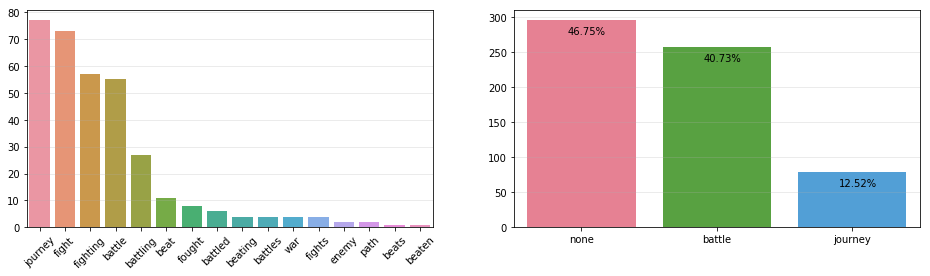

In [7]:
print(f'Total metaphor examples: {len(labeled.loc[labeled["type"] != "none", :])}')

plt.subplots(1, 2, figsize=(16,4))

plt.subplot(1,2,1)
vc = labeled.loc[labeled['type'] != 'none', 'keyword'].value_counts();
sns.barplot(vc.index, vc.values)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1,2,2)
vc = labeled['type'].value_counts()
g = sns.barplot(vc.index, vc.values, palette='husl')
plt.grid(axis='y', alpha=0.3)

s = sum(vc.values)
for p in g.patches:
    h = p.get_height()
    plt.text(p.get_x() + 0.3, h - 20, f'{h/s*100:.2f}%')

### TODO

o how productive a metaphor is (**creatively** using metaphor). 

o is the campaign about raising money for research, product, book, diets, etc. journey as raising money

x add enemy as keyword

o add "fighter" as keyword

o cancer fighting the patient, not the other way around - bring in POS to figure out if cancer is a subject or object, "cancer can’t beat us", "battle scars"

o situational model, looking at prosidy in speech

o measure of distinct words in a campaign

o characterizing metaphors with types of projects

**Instances of Keyword used not in Metaphor**

My wife beat me to the shower

don’t beat around the bush

an underground fight club

Gulf War-influenced The New World